#Figure 8 supplement 1 - Functional imaging

This notebook loads in the data corresponding to figure 8 supplement 1

We then computes the mean intenstity image 8_1A), the local correlation image 8_1B)

## Setup plotting

In [5]:
from showit import image
%matplotlib inline

In [6]:
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

##Loading in the data

In [3]:
from thunder.images import frombinary

path = 's3://neuro-datasets/svoboda-lab/2pRAM-paper/02'

# we only load in the first 100 out of 4044 frames as the data is large
data = frombinary(path + '/images', stop=100)

In [4]:
data

Images
mode: local
dtype: int16
shape: (100, 1682, 1792)

##Detrend timeseries

In [7]:
from numpy import arange, polyfit, polyval

def detrend(y, order=5):
    x = arange(len(y))
    p = polyfit(x, y, order)
    p[-1] = 0
    yy = polyval(p, x)
    return y - yy

detrended = data.toseries().map(detrend).toimages()

## Compute and inspect the mean image

In [8]:
mean = detrended.mean().toarray()

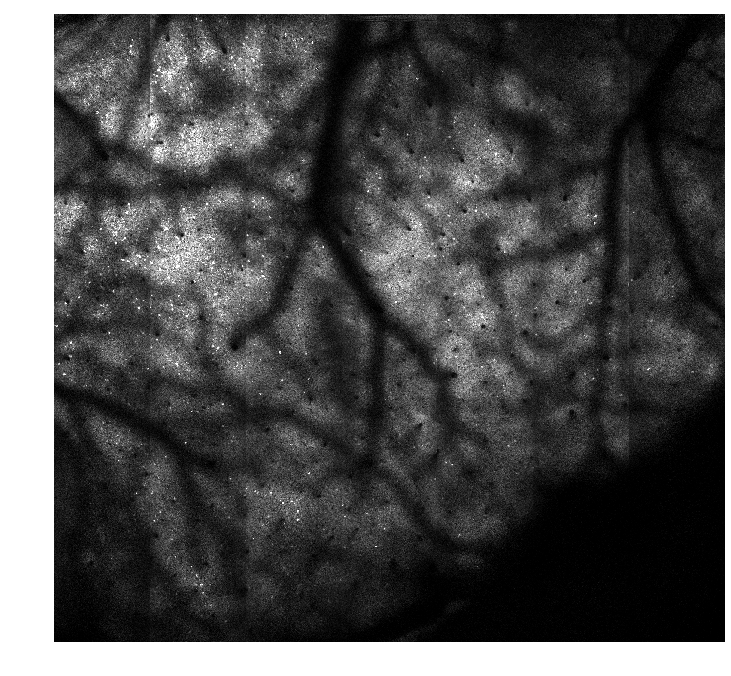

In [9]:
image(mean, clim=(0, 1500), size = 12);

## Compute and inspect local correlation image

In [10]:
localcorr = detrended.localcorr(4)

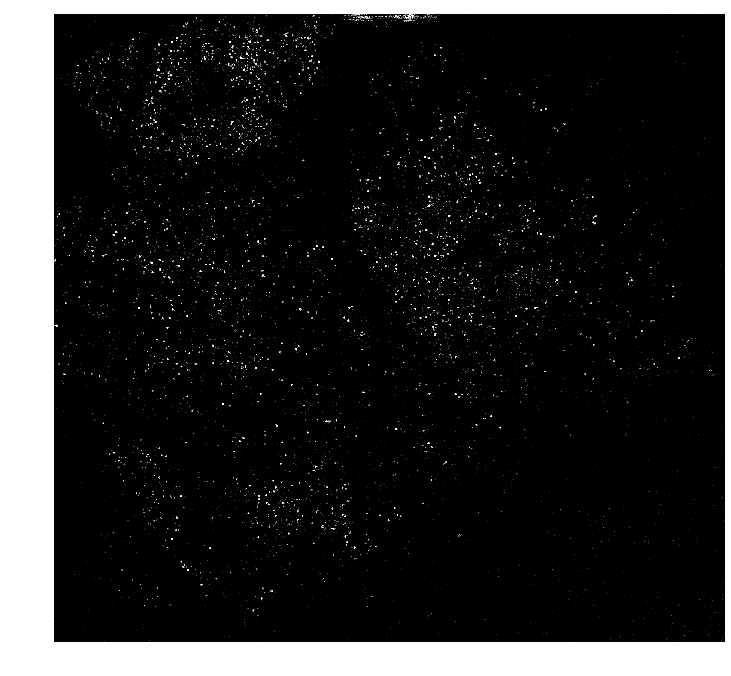

In [11]:
image(localcorr, clim=(0.5, 0.8), size = 12);

##Display sources

In [12]:
from json import loads
from regional import many
from requests import get

path = 'https://s3.amazonaws.com/neuro-datasets/svoboda-lab/2pRAM-paper/02'

r = get(path + '/sources/sources.json').content
sources = loads(r)

regions = many([x['coordinates'] for x in sources])

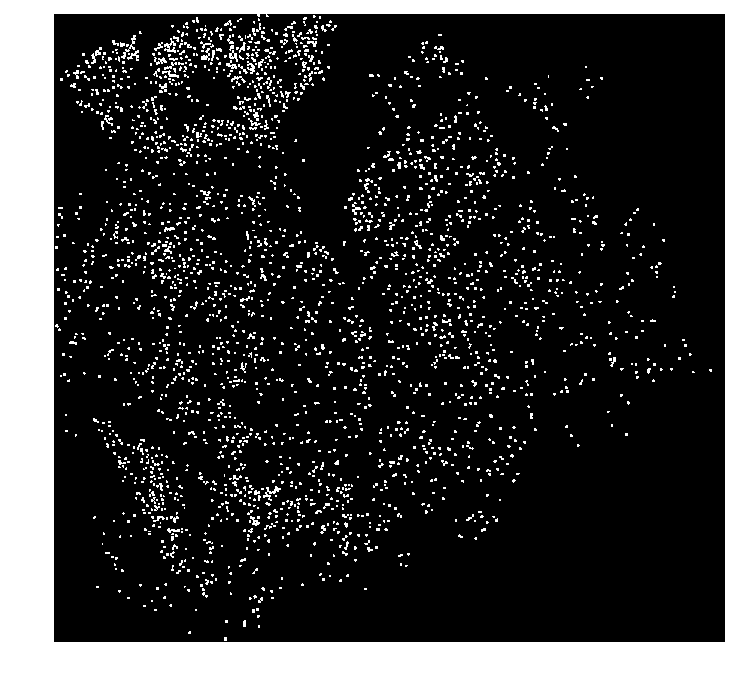

In [13]:
sources = regions.mask(dims=mean.shape, background = 'black', fill = 'white')[:,:,0]
image(sources, size = 12);

##Compute and inspect neuron activity traces

In [15]:
from extraction.model import ExtractionModel

em = ExtractionModel(regions)
traces = em.transform(detrended).normalize('window', window=500)

In [43]:
from numpy import array
time = array([float(x)/1.96 for x in range(traces[0].shape[2])])

In [49]:
# select the 100 neurons with the largest skew
from scipy.stats import skew

skews = skew(traces.values[:,300*1.9:1.9*600],axis=1)
ids = skews.argsort()[-100:][0]

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


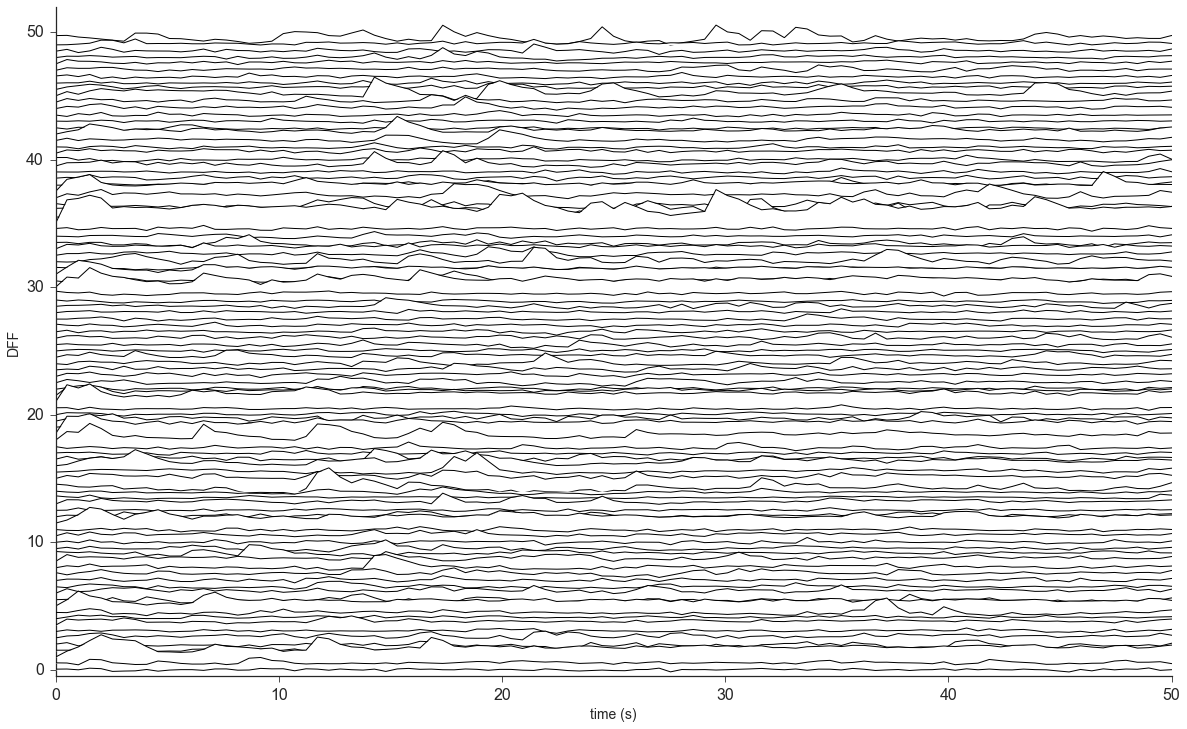

In [52]:
from matplotlib.pyplot import plot, xlim, ylim, xlabel, ylabel, figure, fill_between, savefig 

figure(figsize = (20,12))

for i in range(len(ids)):
    fill_between(time, i/2.0, i/2.0+traces[0, ids[i]].values.T.squeeze(), zorder=20 - 2*i, closed=False,  lw = 0, facecolor = 'white', edgecolor = 'white');
    plot(time, i/2.0 + traces[0, ids[i]].values.T.squeeze(), lw = 1, zorder=20 - (2*i-1), color = 'k');

xlabel('time (s)', fontsize=14);
xlim([0, 50])
ylim([-0.5, 52])
ylabel('DFF', fontsize=14);
sns.despine()